#          IBM Capstone Project 
# "Weather-related car crashes severety prediction"

## Data

### Dataset
The dataset called "Collisions" was provided by Transportation_SeattleCityGIS and obtained from the gisdata.seattle.gov website [6], it contain all the collisions provided by SPD in Seattle and recorded by Traffic Record since 2004 and it is update weekly, at this moment it has 221,525 car crashes reports with 40 different attributes like [7]:
+ Latitude and Longitude.
+ Location (Name or description)
+ Severity
+ Collision Type
+ Enviroment Conditions, etc.

### Features and Labels
To build a Machine Learning model capable of precict the severity of a collision it will be train based on attributes like:
+ The location where the person would transit (longitude, latitude, neighborhood)
+ Date (Day and Month)
+ Time (HH)
+ Weather conditions (Clear, Raining, Overcast, Snowing, etc)
+ Road conditions (Dry, Wet, Slush, etc)
+ Light conditions (Daylight, Dark wit street lights, Dusk, etc)

And it will has the task to predict between one of four possible severity classes:
+ 1 - prop damage
+ 2 - injury
+ 2b - serious injury
+ 3 - fatality

### Data Wrangling
All observations which have an "unknown" severity code, weather, road or light conditions will be drop, a neighborhood attribute will be generate from the coordinates and a geojason file, the date will be separete on day and month attributes and the time transform into a 0-23 integer. Weather, road and light conditions categories will be seprate as one-hot encoded attributes, finally the rest of attributes will be drop.


[6] **Collisions (dataset source)**https://data-seattlecitygis.opendata.arcgis.com/datasets/collisions

[7] **Collisions-All Years (dataset metadata)** https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Metadata.pdf

In [205]:
#pip install tensorflow==2.3.0

In [206]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

In [207]:
DATA = pd.read_csv("Collisions.csv")
print("Dataframe shape:" + str(DATA.shape))

C:\Users\JRodr\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (35) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Dataframe shape:(221525, 40)


In [208]:
df = DATA[["X", "Y", "INCDATE", "INCDTTM", "WEATHER", "ROADCOND", "LIGHTCOND", "SPEEDING", "SEVERITYCODE"]].copy()
df.head()

,X,Y,INCDATE,INCDTTM,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,SEVERITYCODE
0,-122.344896,47.717173,2013/03/14 00:00:00+00,3/14/2013 5:30:00 PM,Clear,Dry,Daylight,NaN,2
1,-122.376467,47.543774,2006/01/15 00:00:00+00,1/15/2006 5:35:00 PM,Overcast,Dry,Dark - Street Lights On,NaN,2
2,-122.360735,47.701487,2019/09/09 00:00:00+00,9/9/2019 3:32:00 PM,Overcast,Wet,Daylight,NaN,1
3,-122.297415,47.599233,2019/12/19 00:00:00+00,12/19/2019,NaN,NaN,NaN,NaN,1
4,-122.368001,47.653585,2013/03/27 00:00:00+00,3/27/2013,NaN,NaN,NaN,NaN,0


In [209]:
df.dropna(axis = "index",
         how = "any",
         subset = ["X", "Y", "INCDATE", "INCDTTM", "WEATHER","ROADCOND","LIGHTCOND", "SEVERITYCODE"],
         inplace = True)
df = df.loc[df.INCDTTM.str.len() > 10]
df = df.loc[df.WEATHER != "Unknown"]
df = df.loc[df.ROADCOND != "Unknown"]
df = df.loc[df.LIGHTCOND != "Unknown"]

df.count()

X               149296
Y               149296
INCDATE         149296
INCDTTM         149296
WEATHER         149296
ROADCOND        149296
LIGHTCOND       149296
SPEEDING          7717
SEVERITYCODE    149296
dtype: int64

In [260]:
clean_df = df[["X", "Y"]].copy()
clean_df["MONTH"] = pd.DatetimeIndex(df["INCDATE"]).month
clean_df["DAY"] = pd.DatetimeIndex(df["INCDATE"]).day
clean_df["HOUR"] = pd.DatetimeIndex(df["INCDTTM"]).hour
clean_df["WEEKDAY"] = pd.DatetimeIndex(df["INCDTTM"]).weekday
clean_df = pd.concat([clean_df, pd.get_dummies(df["WEATHER"])], axis = 1)
clean_df = pd.concat([clean_df, pd.get_dummies(df["ROADCOND"])], axis = 1)
clean_df = pd.concat([clean_df, pd.get_dummies(df["LIGHTCOND"])], axis = 1)
clean_df["SPEEDING"] = df["SPEEDING"]
clean_df.replace([np.nan, "Y"], [0, 1], inplace = True)
clean_df["SEVERITYCODE"] = df["SEVERITYCODE"]
clean_df.head()

,X,Y,MONTH,DAY,HOUR,WEEKDAY,Blowing Sand/Dirt,Clear,Fog/Smog/Smoke,Other,...,Dark - No Street Lights,Dark - Street Lights Off,Dark - Street Lights On,Dark - Unknown Lighting,Dawn,Daylight,Dusk,Other,SPEEDING,SEVERITYCODE
0,-122.344896,47.717173,3,14,17,3,0,1,0,0,...,0,0,0,0,0,1,0,0,0,2
1,-122.376467,47.543774,1,15,17,6,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
2,-122.360735,47.701487,9,9,15,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
6,-122.338635,47.625796,7,31,10,4,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
8,-122.313891,47.653560,4,11,16,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1


In [264]:
X = clean_df.drop("SEVERITYCODE", axis = 1)
print("X shape: " + str(X.shape) + "\n")

X shape: (149296, 33)



In [265]:
Y = pd.get_dummies(clean_df["SEVERITYCODE"])
labels_codes = Y.columns
Y = Y.values

#print(labels_codes)
print("\nY shape:" + str(Y.shape)+ "\n")
Y[:5]


Y shape:(149296, 4)



array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]], dtype=uint8)

,X
SEVERITYCODE,
1,97860
2,48585
2b,2569
3,282


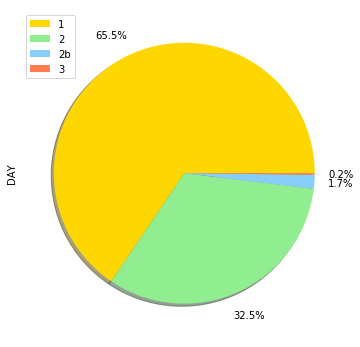

In [213]:
colors = ['gold', 'lightgreen', 'lightskyblue', 'coral']

clean_df[["SEVERITYCODE", "DAY"]].groupby("SEVERITYCODE").count().DAY.plot(kind = "pie",
                                                                      figsize=(12, 6),
                                                                      autopct='%1.1f%%',
                                                                      pctdistance=1.2,
                                                                      labels = None,
                                                                      colors = colors,
                                                                      shadow = True)

plt.legend(labels=labels_codes, loc='upper left') 

clean_df[["SEVERITYCODE", "X"]].groupby("SEVERITYCODE",0).count()


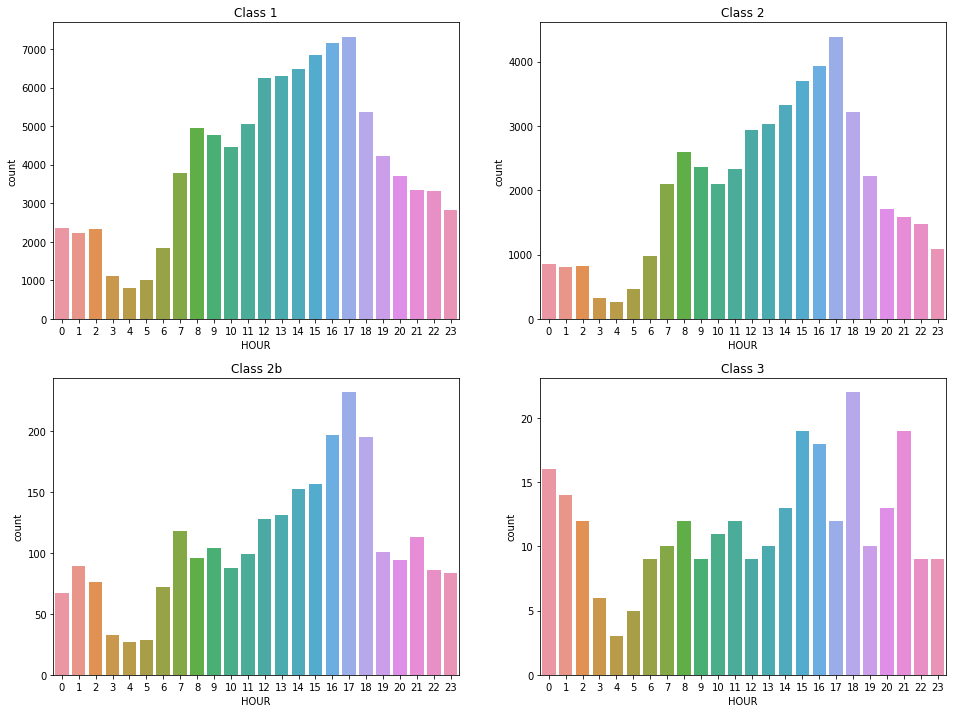

In [267]:
Fig = plt.figure(figsize = (16,12))
ax1 = Fig.add_subplot(2,2,1)
ax2 = Fig.add_subplot(2,2,2)
ax3 = Fig.add_subplot(2,2,3)
ax4 = Fig.add_subplot(2,2,4)

sns.countplot(x = "HOUR", data = clean_df[clean_df["SEVERITYCODE"] == "1"], ax = ax1)
ax1.set_title("Class 1")
sns.countplot(x = "HOUR", data = clean_df[clean_df["SEVERITYCODE"] == "2"], ax = ax2)
ax2.set_title("Class 2")
sns.countplot(x = "HOUR", data = clean_df[clean_df["SEVERITYCODE"] == "2b"], ax = ax3)
ax3.set_title("Class 2b")
sns.countplot(x = "HOUR", data = clean_df[clean_df["SEVERITYCODE"] == "3"], ax = ax4)
ax4.set_title("Class 3")
fig.savefig('Hours.jpeg')

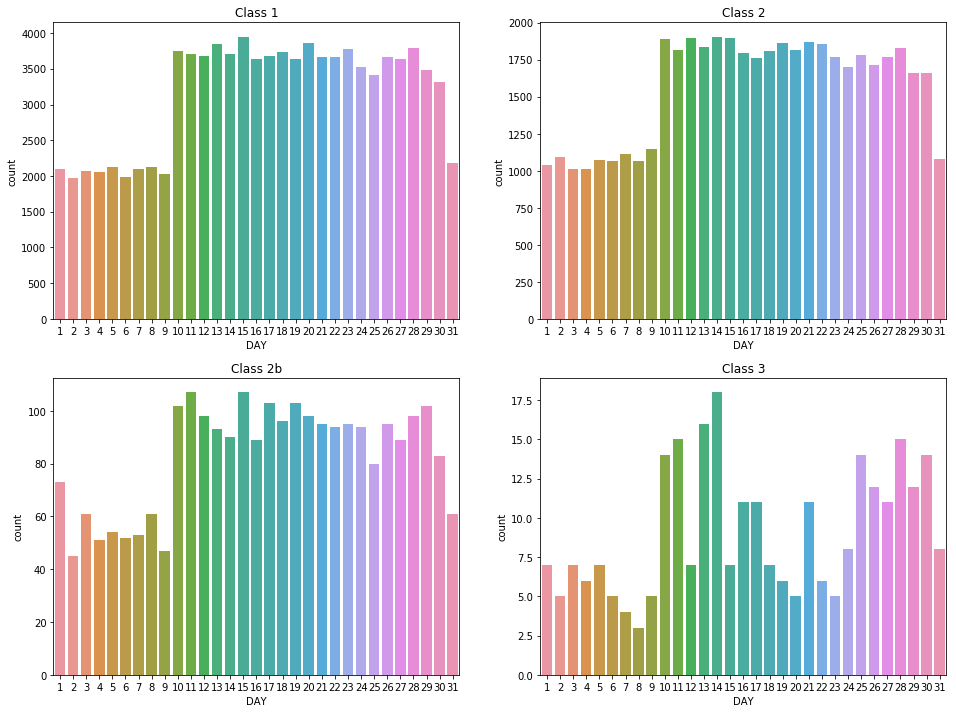

In [268]:
Fig = plt.figure(figsize = (16,12))
ax1 = Fig.add_subplot(2,2,1)
ax2 = Fig.add_subplot(2,2,2)
ax3 = Fig.add_subplot(2,2,3)
ax4 = Fig.add_subplot(2,2,4)

sns.countplot(x = "DAY", data = clean_df[clean_df["SEVERITYCODE"] == "1"], ax = ax1)
ax1.set_title("Class 1")
sns.countplot(x = "DAY", data = clean_df[clean_df["SEVERITYCODE"] == "2"], ax = ax2)
ax2.set_title("Class 2")
sns.countplot(x = "DAY", data = clean_df[clean_df["SEVERITYCODE"] == "2b"], ax = ax3)
ax3.set_title("Class 2b")
sns.countplot(x = "DAY", data = clean_df[clean_df["SEVERITYCODE"] == "3"], ax = ax4)
ax4.set_title("Class 3")
fig.savefig('Days.jpeg')

Text(0.5, 1.0, 'Class 3')

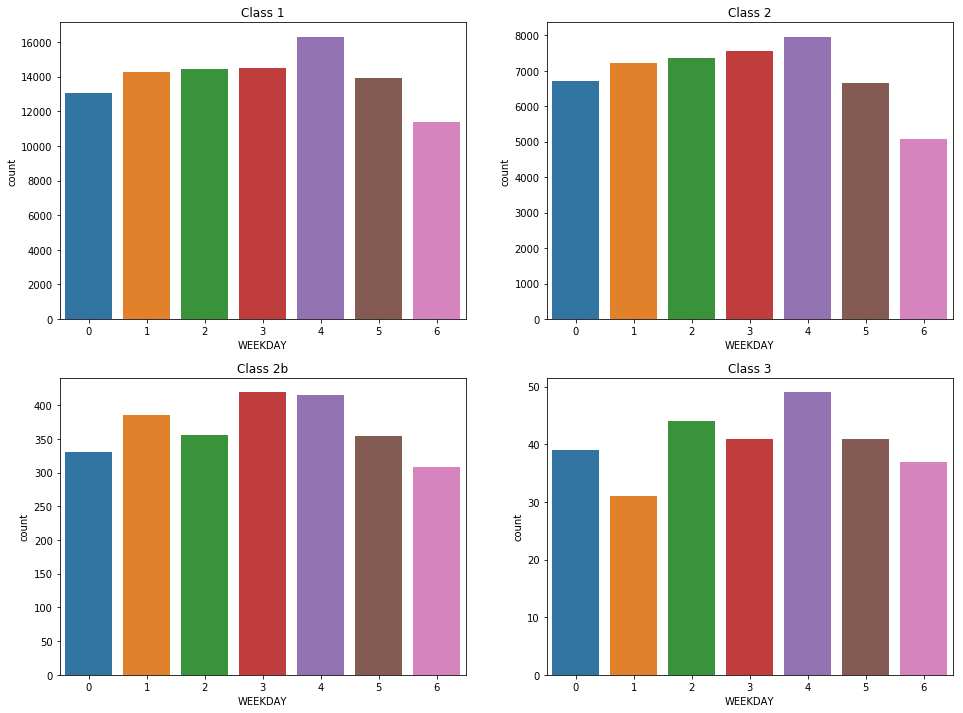

In [262]:
Fig = plt.figure(figsize = (16,12))
ax1 = Fig.add_subplot(2,2,1)
ax2 = Fig.add_subplot(2,2,2)
ax3 = Fig.add_subplot(2,2,3)
ax4 = Fig.add_subplot(2,2,4)

sns.countplot(x = "WEEKDAY", data = clean_df[clean_df["SEVERITYCODE"] == "1"], ax = ax1)
ax1.set_title("Class 1")
sns.countplot(x = "WEEKDAY", data = clean_df[clean_df["SEVERITYCODE"] == "2"], ax = ax2)
ax2.set_title("Class 2")
sns.countplot(x = "WEEKDAY", data = clean_df[clean_df["SEVERITYCODE"] == "2b"], ax = ax3)
ax3.set_title("Class 2b")
sns.countplot(x = "WEEKDAY", data = clean_df[clean_df["SEVERITYCODE"] == "3"], ax = ax4)
ax4.set_title("Class 3")

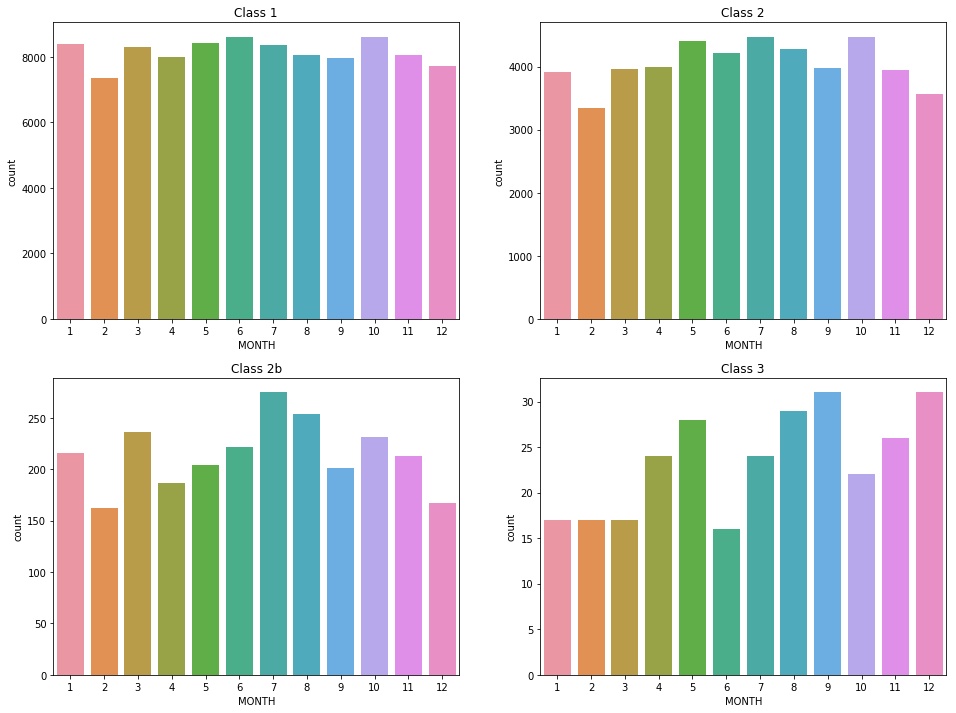

In [269]:
Fig = plt.figure(figsize = (16,12))
ax1 = Fig.add_subplot(2,2,1)
ax2 = Fig.add_subplot(2,2,2)
ax3 = Fig.add_subplot(2,2,3)
ax4 = Fig.add_subplot(2,2,4)

sns.countplot(x = "MONTH", data = clean_df[clean_df["SEVERITYCODE"] == "1"], ax = ax1)
ax1.set_title("Class 1")
sns.countplot(x = "MONTH", data = clean_df[clean_df["SEVERITYCODE"] == "2"], ax = ax2)
ax2.set_title("Class 2")
sns.countplot(x = "MONTH", data = clean_df[clean_df["SEVERITYCODE"] == "2b"], ax = ax3)
ax3.set_title("Class 2b")
sns.countplot(x = "MONTH", data = clean_df[clean_df["SEVERITYCODE"] == "3"], ax = ax4)
ax4.set_title("Class 3")
fig.savefig('Month.jpeg')

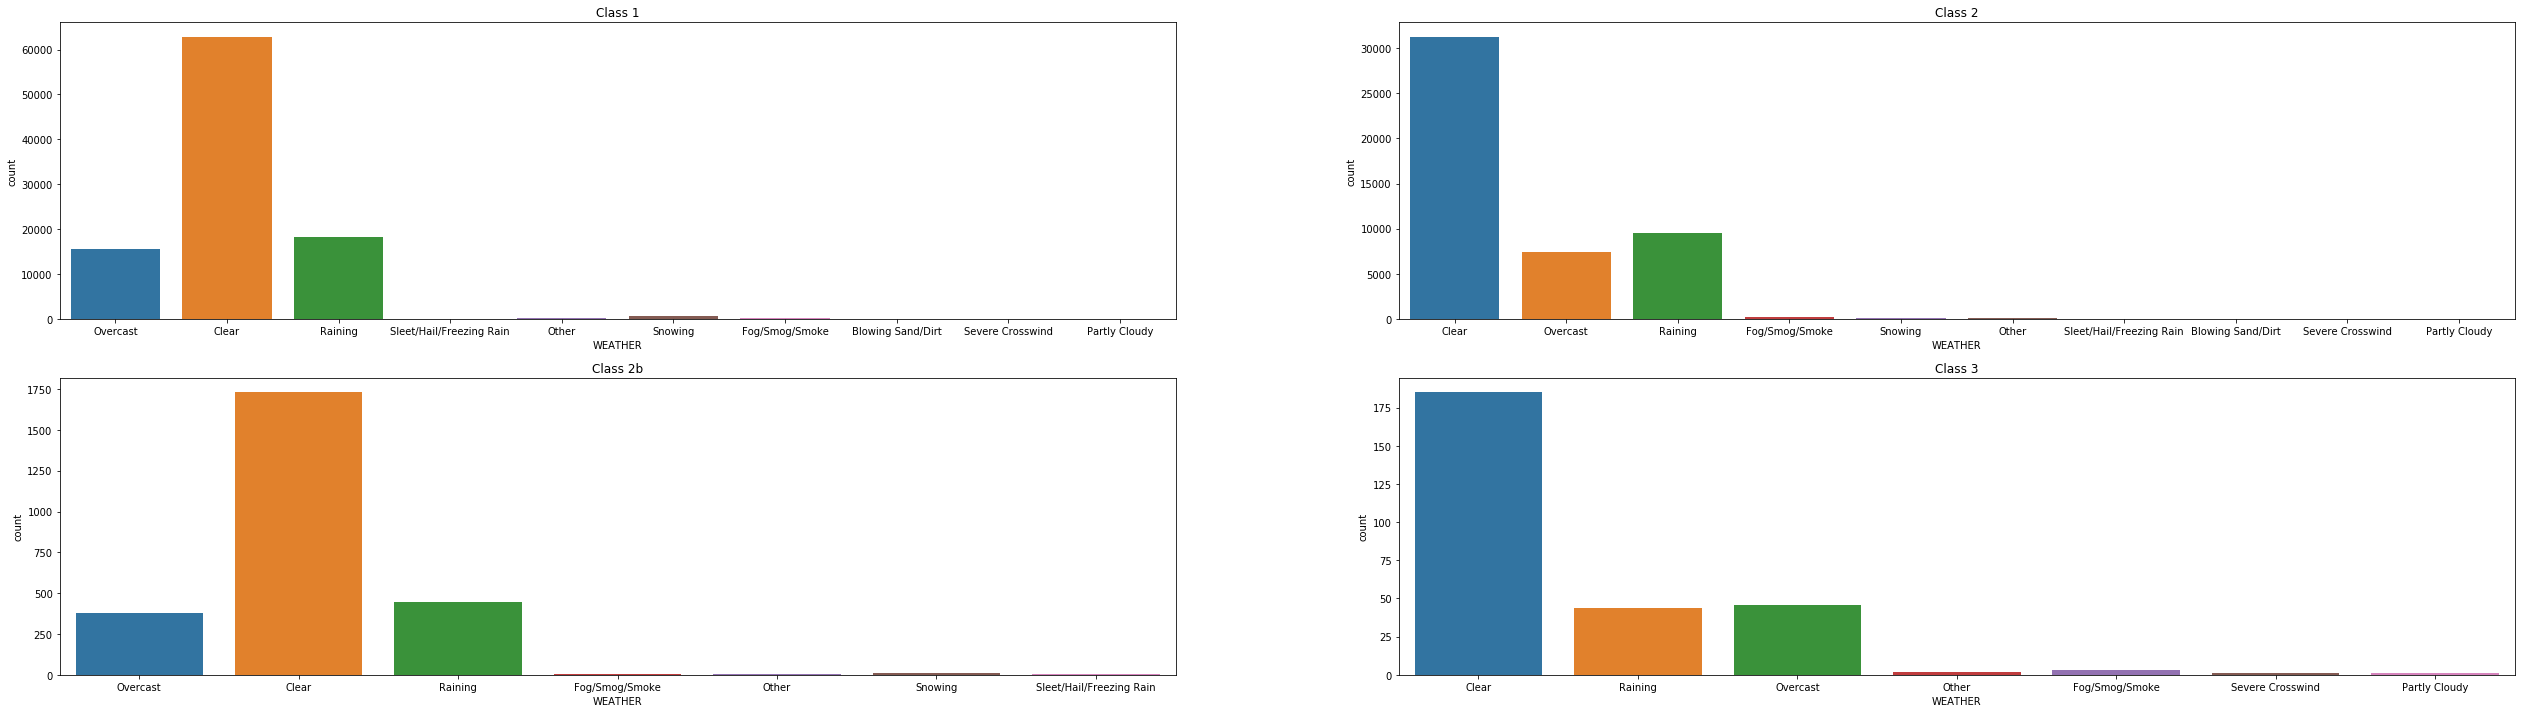

In [274]:
Fig = plt.figure(figsize = (44,12))
ax1 = Fig.add_subplot(2,2,1)
ax2 = Fig.add_subplot(2,2,2)
ax3 = Fig.add_subplot(2,2,3)
ax4 = Fig.add_subplot(2,2,4)

sns.countplot(x = "WEATHER", data = df[df["SEVERITYCODE"] == "1"],  ax = ax1)
ax1.set_title("Class 1")
sns.countplot(x = "WEATHER", data = df[df["SEVERITYCODE"] == "2"], ax = ax2)
ax2.set_title("Class 2")
sns.countplot(x = "WEATHER", data = df[df["SEVERITYCODE"] == "2b"], ax = ax3)
ax3.set_title("Class 2b")
sns.countplot(x = "WEATHER", data = df[df["SEVERITYCODE"] == "3"], ax = ax4)
ax4.set_title("Class 3")
fig.savefig('Weather.jpeg')

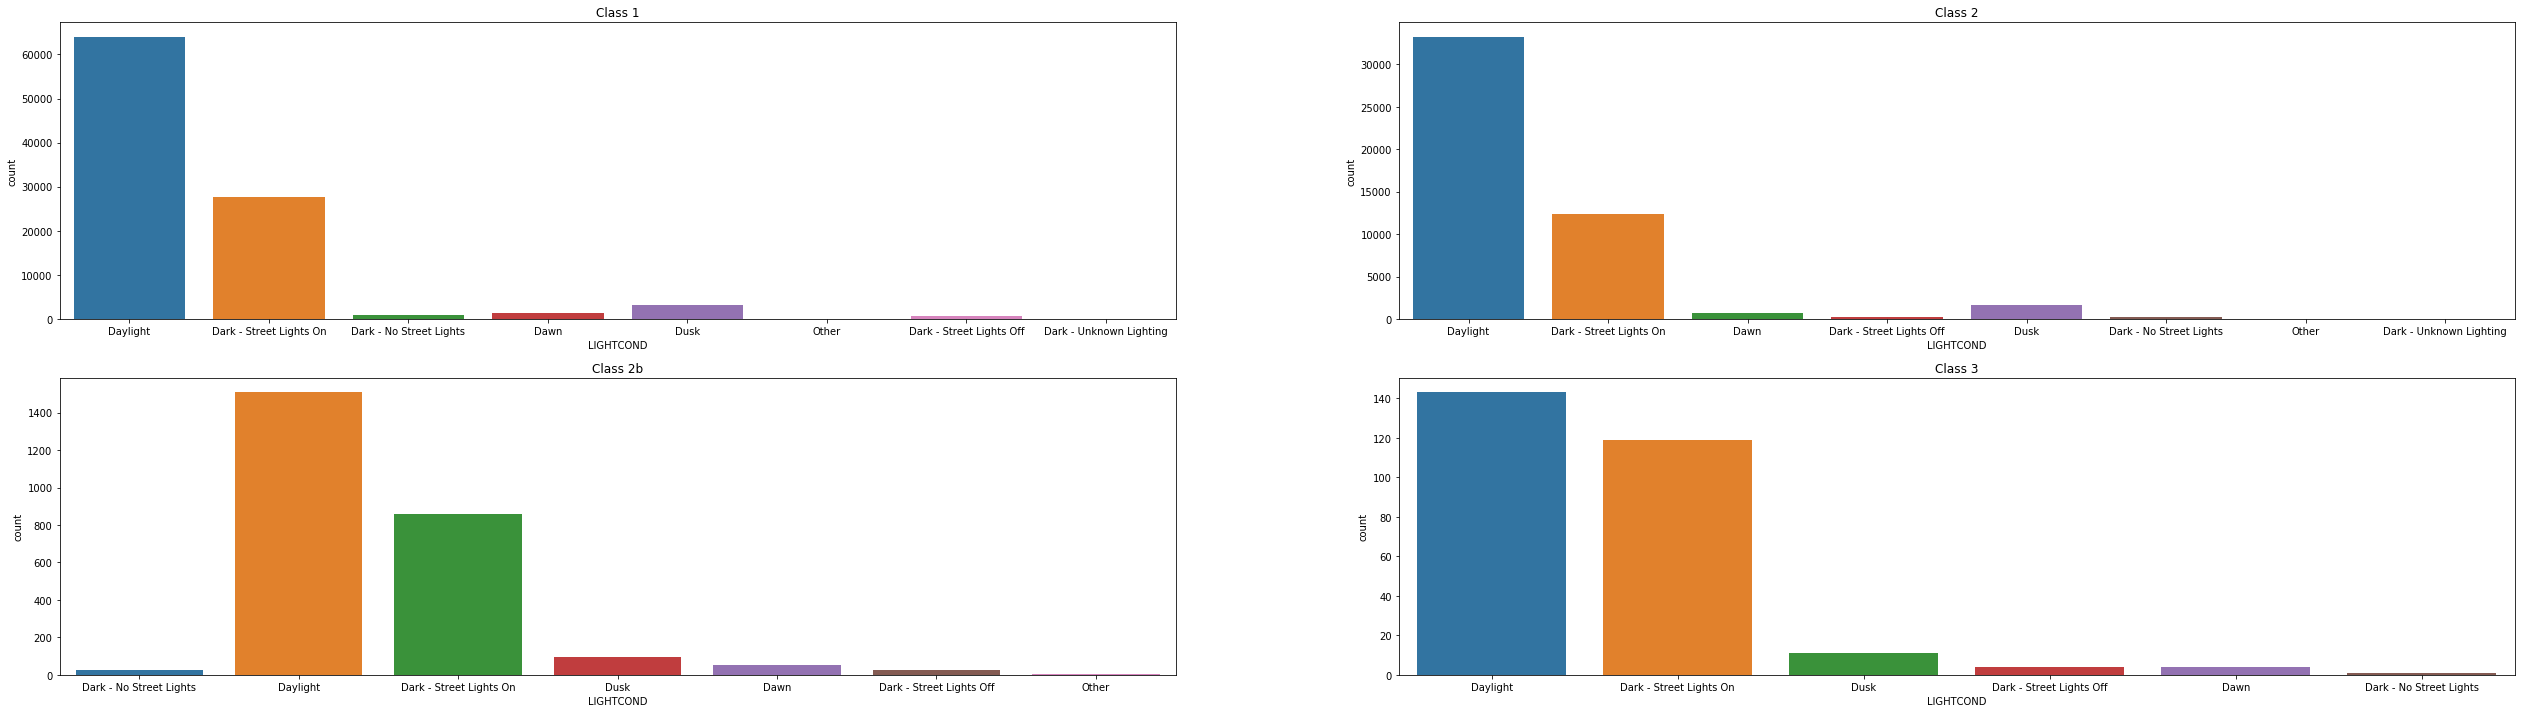

In [280]:
Fig = plt.figure(figsize = (44,12))
ax1 = Fig.add_subplot(2,2,1)
ax2 = Fig.add_subplot(2,2,2)
ax3 = Fig.add_subplot(2,2,3)
ax4 = Fig.add_subplot(2,2,4)

sns.countplot(x = "LIGHTCOND", data = df[df["SEVERITYCODE"] == "1"],  ax = ax1)
ax1.set_title("Class 1")
sns.countplot(x = "LIGHTCOND", data = df[df["SEVERITYCODE"] == "2"], ax = ax2)
ax2.set_title("Class 2")
sns.countplot(x = "LIGHTCOND", data = df[df["SEVERITYCODE"] == "2b"], ax = ax3)
ax3.set_title("Class 2b")
sns.countplot(x = "LIGHTCOND", data = df[df["SEVERITYCODE"] == "3"], ax = ax4)
ax4.set_title("Class 3")
fig.savefig('LightCond.jpeg')

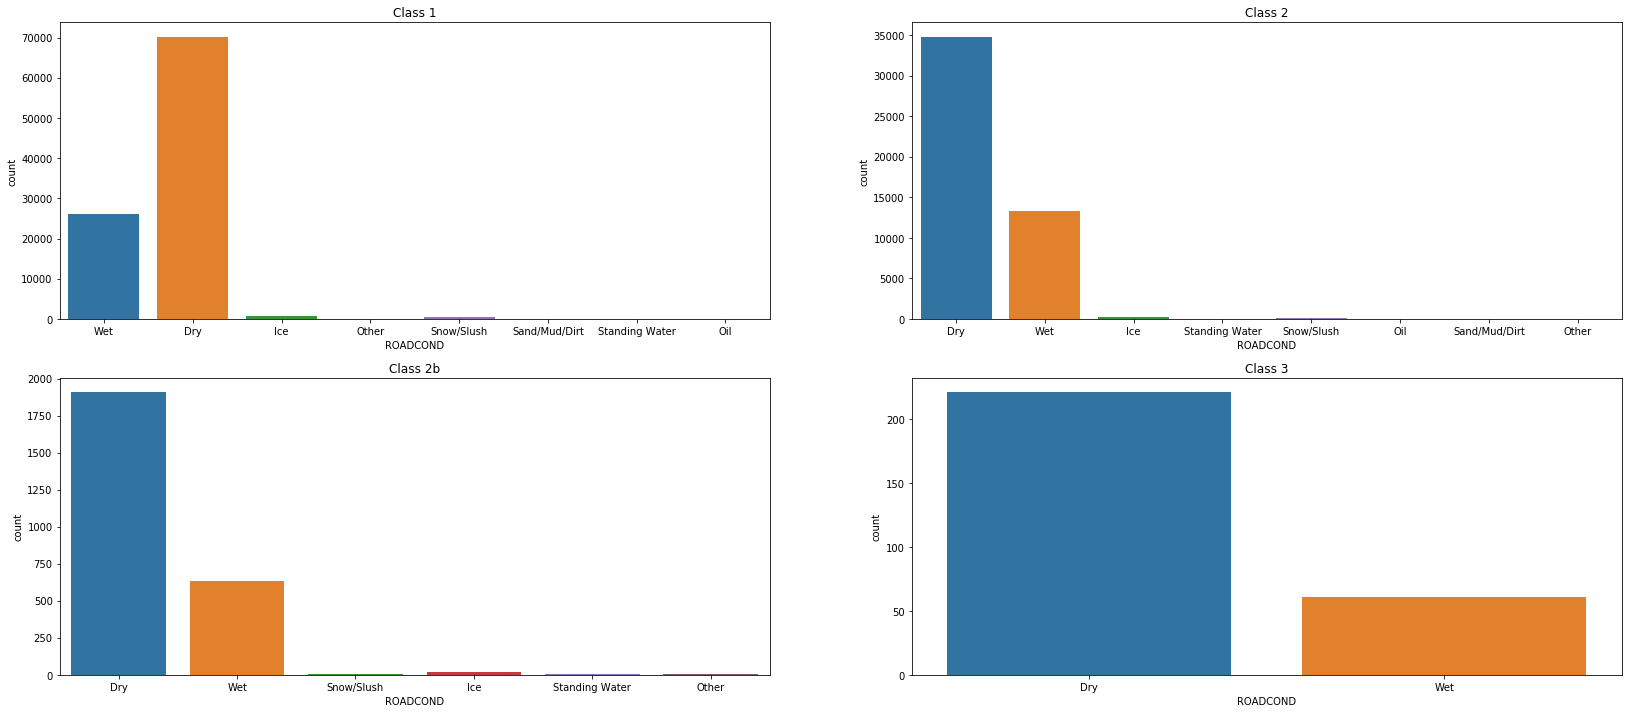

In [281]:
Fig = plt.figure(figsize = (28,12))
ax1 = Fig.add_subplot(2,2,1)
ax2 = Fig.add_subplot(2,2,2)
ax3 = Fig.add_subplot(2,2,3)
ax4 = Fig.add_subplot(2,2,4)

sns.countplot(x = "ROADCOND", data = df[df["SEVERITYCODE"] == "1"],  ax = ax1)
ax1.set_title("Class 1")
sns.countplot(x = "ROADCOND", data = df[df["SEVERITYCODE"] == "2"], ax = ax2)
ax2.set_title("Class 2")
sns.countplot(x = "ROADCOND", data = df[df["SEVERITYCODE"] == "2b"], ax = ax3)
ax3.set_title("Class 2b")
sns.countplot(x = "ROADCOND", data = df[df["SEVERITYCODE"] == "3"], ax = ax4)
ax4.set_title("Class 3")
fig.savefig('RoadCond.jpeg')

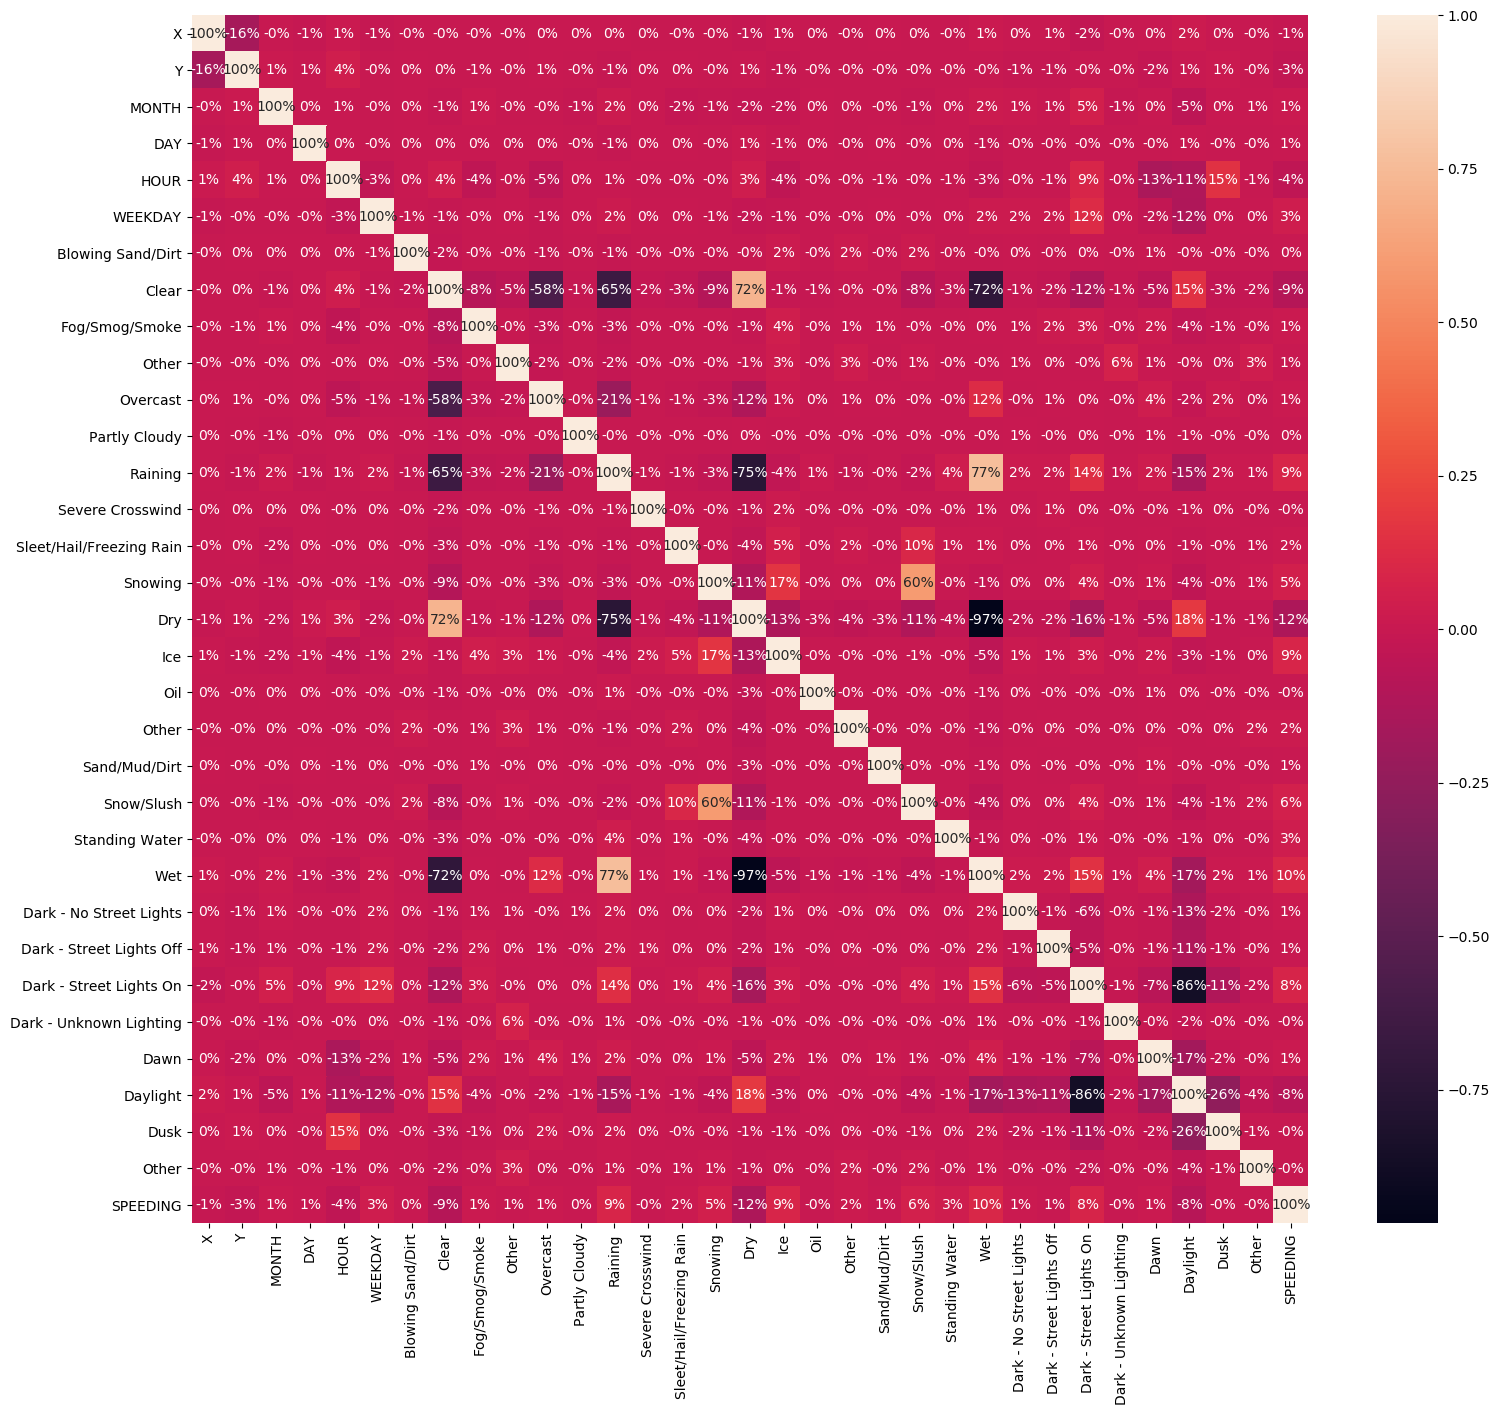

In [282]:
plt.figure(figsize = (18,16), dpi = 100)
sns.heatmap(X.corr(), annot = True, fmt = '.0%')
fig.savefig('Corr.jpeg')

In [283]:
import folium
from folium import plugins

long = clean_df["X"].median()
lat = clean_df["Y"].median()

CrashesPerClass = 100

class_1_indexes = np.where(Y[:,0] == 1)
class_2_indexes = np.where(Y[:,1] == 1)
class_2b_indexes = np.where(Y[:,2] == 1)
class_3_indexes = np.where(Y[:,3] == 1)

class_1_size = int(np.size(class_1_indexes))
class_2_size = int(np.size(class_2_indexes))
class_2b_size = int(np.size(class_2b_indexes))
class_3_size = int(np.size(class_3_indexes))

class_1_indexes = np.random.choice(np.reshape(class_1_indexes, class_1_size), CrashesPerClass)
Crashes = clean_df.iloc[class_1_indexes]

class_2_indexes = np.random.choice(np.reshape(class_2_indexes, class_2_size), CrashesPerClass)
Crashes = pd.concat( [Crashes, clean_df.iloc[class_2_indexes]], axis = 0)

class_2b_indexes = np.random.choice(np.reshape(class_2b_indexes,class_2b_size), CrashesPerClass)
Crashes = pd.concat( [Crashes, clean_df.iloc[class_2b_indexes]], axis = 0)

class_3_indexes = np.random.choice(np.reshape(class_3_indexes,class_3_size), CrashesPerClass)
Crashes = pd.concat( [Crashes, clean_df.iloc[class_3_indexes]], axis = 0)

#Crashes = clean_df.loc[clean_df.SEVERITYCODE == "3"]

plt.figure(figsize=(6, 4), dpi = 100)
seattle_map = folium.Map(location=[lat, long], zoom_start=12)

# instantiate a mark cluster object for the incidents in the dataframe
crashes = plugins.MarkerCluster().add_to(seattle_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(Crashes.Y, Crashes.X, Crashes.SEVERITYCODE):
    if label == "1":
        color = "green"
    if label == "2":
        color = "yellow"
    if label == "2b":
        color = "red"
    if label == "3":
        color = "black"
        
    seattle_map.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color=color,
            fill=True, 
            popup = label,
            fill_color=color,
            fill_opacity=0.6
        )
    )

# display world map
fig.savefig('Map.jpeg')
seattle_map

<Figure size 600x400 with 0 Axes>

In [219]:
x_train, x_test, y_train, y_test = train_test_split(
    X, 
    Y,
    test_size = 0.2,
    random_state = 0
)
print("x_train shape:" + str(x_train.shape))
print("y_train shape:" + str(y_train.shape))
print("x_test shape:" + str(x_test.shape))
print("y_test shape:" + str(y_test.shape))

x_train shape:(119436, 32)
y_train shape:(119436, 4)
x_test shape:(29860, 32)
y_test shape:(29860, 4)


In [220]:
#Oversample classes "2b" and "3", and undersample  class "1" from the train set

#Undersampling Class 1 
class_1_indexes = np.where(y_train[:,0] == 1)
indexes2delete = np.random.choice(np.reshape(class_1_indexes,int(np.size(class_1_indexes))), int(np.size(class_1_indexes)*0.5))
new_x_train = np.delete(np.array(x_train), indexes2delete, 0)
new_y_train = np.delete(np.array(y_train), indexes2delete, 0)

#Oversampling Class 2b and 3
class_2b_indexes = np.where(y_train[:,2] == 1)
class_3_indexes = np.where(y_train[:,3] == 1)

for i in range(19):
    new_x_train = np.concatenate((new_x_train, np.array(x_train)[class_2b_indexes,:][0,:,:]), axis = 0)
    new_y_train = np.concatenate((new_y_train, np.array(y_train)[class_2b_indexes,:][0,:,:]), axis = 0)
for i in range(120):  
    new_x_train = np.concatenate((new_x_train, np.array(x_train)[class_3_indexes,:][0,:,:]), axis = 0)
    new_y_train = np.concatenate((new_y_train, np.array(y_train)[class_3_indexes,:][0,:,:]), axis = 0)

x_train = new_x_train
y_train = new_y_train

np.shape(new_x_train)

(155061, 32)

In [221]:
Tree = DecisionTreeClassifier(criterion="entropy", max_depth = 40, class_weight ="balanced")
Tree.fit(x_train,y_train)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_train, Tree.predict(x_train)))
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, Tree.predict(x_test)))

print("F1 Score: %.2f" % metrics.f1_score( y_test, Tree.predict(x_test), average='weighted'))

DecisionTrees's Accuracy:  0.9986456942751563
DecisionTrees's Accuracy:  0.5045545880776959
F1 Score: 0.52


In [222]:
Forest = RandomForestClassifier(n_estimators = 15, criterion = "entropy", random_state = 0, class_weight ="balanced")
Forest.fit(x_train, y_train)

print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_train, Forest.predict(x_train)))
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, Forest.predict(x_test)))
print("F1 Score: %.2f" % metrics.f1_score(y_test, Forest.predict(x_test), average='weighted'))

DecisionTrees's Accuracy:  0.9959499809752291
DecisionTrees's Accuracy:  0.500468854655057
F1 Score: 0.52


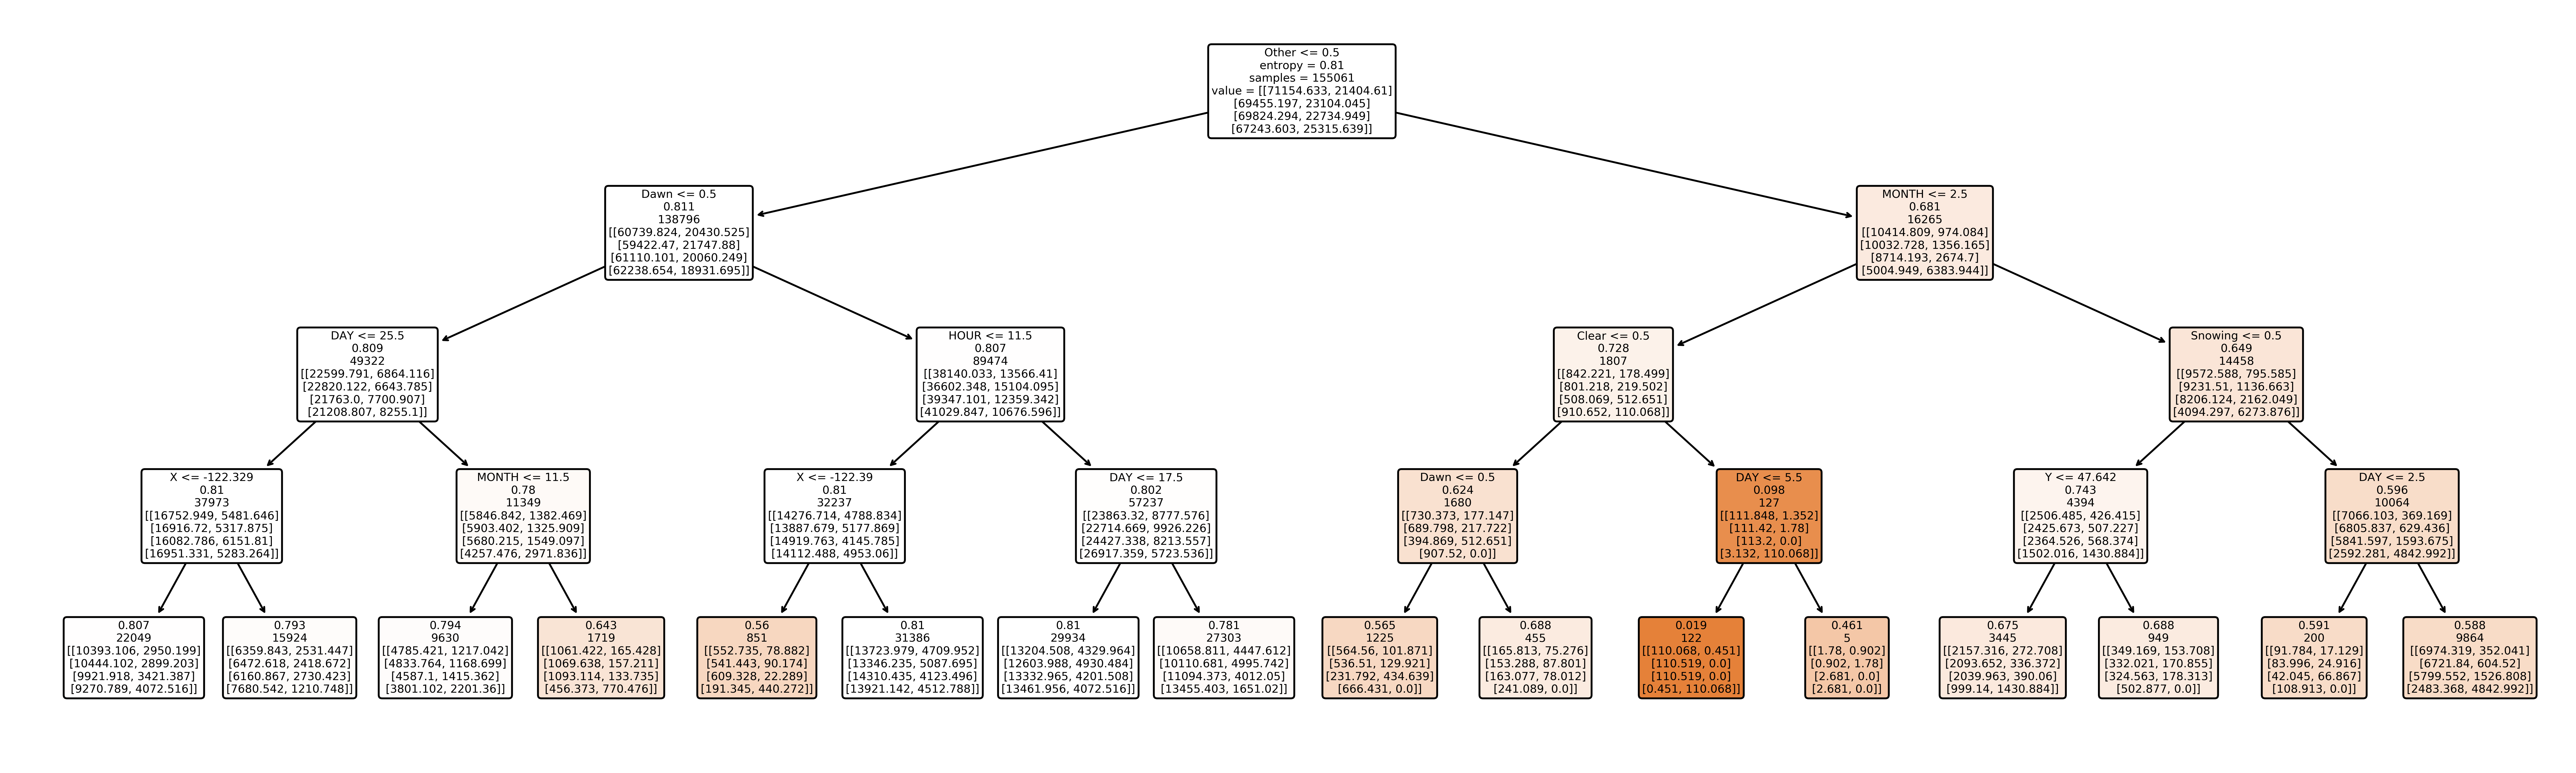

In [284]:
from sklearn import tree

Tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4, class_weight ="balanced")
Tree.fit(x_train,y_train)

fn =list(X.columns)
cn=['Prop damage', 'injure', 'several injure', 'fatality']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (24,7), dpi=512)
tree.plot_tree(Tree,
               feature_names = fn, 
               class_names=cn,
               filled = True,
               label = 'root',
               rounded = True,
              fontsize = 6);
fig.savefig('Tree.png')

In [193]:
class_1_indexes = np.where(Y[:,0] == 1)
class_1_size = np.array(class_1_indexes).shape[1]
any_injure_class_size = Y.shape[0] - class_1_size

#Undersampling Class 1 
number_to_delete = class_1_size - any_injure_class_size 
indexes2delete = np.random.choice(np.reshape(class_1_indexes,class_1_size), number_to_delete, replace = False)

new_X = np.delete(np.array(X), indexes2delete, 0)
new_Y = np.delete(np.array(Y), indexes2delete, 0)

class_2b_indexes = np.where(new_Y[:,2] == 1)
class_3_indexes = np.where(new_Y[:,3] == 1)

new_Y[class_2b_indexes,1] = 1
new_Y[class_3_indexes,1] = 1
new_Y = np.delete(np.array(new_Y), [0,2,3], 1)

x_train, x_test, y_train, y_test = train_test_split(
    new_X, 
    new_Y,
    test_size = 0.2,
    random_state = 0
)

#StdScaler = preprocessing.StandardScaler().fit(x_train)
#x_train = StdScaler.transform(x_train)
#x_test = StdScaler.transform(x_test)

print("x_train shape: " + str(np.shape(x_train))+ "\n")
print("Distribution :" + str(y_train.sum(0)) + "\n")

x_train shape: (82297, 32)

Distribution :[41264]



In [232]:
with tf.device('/GPU:0'):
    model = Sequential()
    model.add(Dense(units = 2048, activation = 'relu'))#, kernel_regularizer=tf.keras.regularizers.l2(0.001)  ))
    model.add(Dense(units = 2048, activation = 'relu'))#, kernel_regularizer=tf.keras.regularizers.l2(0.001)  ))
    model.add(Dense(units = 2048, activation = 'relu'))#, kernel_regularizer=tf.keras.regularizers.l2(0.001)  ))
    #model.add(Dropout(0.5))

    model.add(Dense(units = 4, activation = 'softmax' ))
    
    checkpoint_name = 'Best-Weights.hdf5' 
    checkpoint = ModelCheckpoint(checkpoint_name, 
                                 monitor='val_loss', 
                                 verbose = 0, 
                                 save_best_only = True, 
                                 mode ='auto')
    callbacks_list = [checkpoint]

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss = 'CategoricalCrossentropy',
                  metrics = ['Accuracy'] )


    history = model.fit(x_train, y_train, 
                        batch_size = 20,
                        epochs = 40, 
                        verbose = 2, 
                        validation_data = (x_test, y_test),
                        shuffle = True,
                        callbacks=callbacks_list)

wights_file = 'Best-Weights.hdf5'  # choose the best checkpoint 
model.load_weights(wights_file) # load it
model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['Accuracy'])

Epoch 1/40
7754/7754 - 24s - loss: 1.3985 - accuracy: 1.1125e-04 - val_loss: 1.2799 - val_accuracy: 0.0000e+00
Epoch 2/40
7754/7754 - 24s - loss: 1.3695 - accuracy: 0.0000e+00 - val_loss: 1.2595 - val_accuracy: 0.0000e+00
Epoch 3/40
7754/7754 - 23s - loss: 1.3692 - accuracy: 0.0000e+00 - val_loss: 1.2699 - val_accuracy: 0.0000e+00
Epoch 4/40
7754/7754 - 24s - loss: 1.3691 - accuracy: 0.0000e+00 - val_loss: 1.2450 - val_accuracy: 0.0000e+00
Epoch 5/40
7754/7754 - 24s - loss: 1.3691 - accuracy: 0.0000e+00 - val_loss: 1.2650 - val_accuracy: 0.0000e+00
Epoch 6/40
7754/7754 - 24s - loss: 1.3691 - accuracy: 0.0000e+00 - val_loss: 1.2586 - val_accuracy: 0.0000e+00
Epoch 7/40
7754/7754 - 24s - loss: 1.3691 - accuracy: 0.0000e+00 - val_loss: 1.2528 - val_accuracy: 0.0000e+00
Epoch 8/40
7754/7754 - 24s - loss: 1.3691 - accuracy: 0.0000e+00 - val_loss: 1.2505 - val_accuracy: 0.0000e+00
Epoch 9/40
7754/7754 - 23s - loss: 1.3691 - accuracy: 0.0000e+00 - val_loss: 1.2478 - val_accuracy: 0.0000e+00
E

KeyboardInterrupt: 

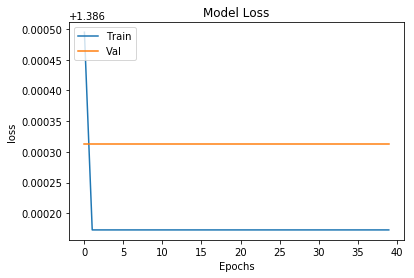

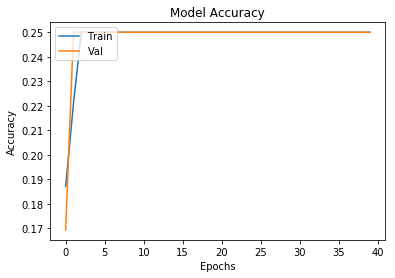

Best epoch: 0
Best loss: 1.386312484741211
Kappa: 0.68


In [230]:
plt.plot(history.history['loss'])
plt.plot( history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()


plt.plot(history.history['accuracy'])
plt.plot( history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()

test_y_hat = model.predict(x_test)

print("Best epoch: " + str(np.argmin(history.history['val_loss'])))
print("Best loss: " + str(min(history.history['val_loss'])))
print("Kappa: %.2f" % metrics.f1_score(y_test, np.round(test_y_hat), average='weighted') )